In [196]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
import sys
sys.path.append("/content/drive/MyDrive/")

In [1]:
from transformers import ViTForImageClassification,ViTConfig, ViTImageProcessor
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from tqdm import tqdm
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
from pathlib import Path

from utils import load_dataset

2024-01-11 14:50:46.095487: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 14:50:46.123969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 14:50:46.356168: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 14:50:46.357403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:50:47.202286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
save_path = Path("model.pch")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Freeze le model
for parameter in  model.parameters() :
  parameter.requires_grad = False

# Changer la derniere couche
nb_classe = 2
model.classifier = nn.Linear(model.config.hidden_size, nb_classe)

In [201]:
train_images, train_labels = load_dataset(test=False, color=False)
test_images, test_labels = load_dataset(test=True, color=False)

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

tensor_tr = torch.stack([transform_data(image) for image in train_images])
tensor_ts = torch.stack([transform_data(image) for image in test_images])


tensor_test = tensor_ts.expand(-1, 3, -1, -1).to(torch.float32)
tensor_train = tensor_tr.expand(-1, 3, -1, -1).to(torch.float32)

train_tensor = TensorDataset(tensor_train,torch.tensor(label_train, dtype = torch.long))
test_tensor = TensorDataset(tensor_test,torch.tensor(label_test, dtype = torch.long))

BATCH_SIZE = 32

Train = DataLoader(train_tensor,shuffle=True, batch_size = BATCH_SIZE)
Test = DataLoader(test_tensor,shuffle = False)

In [202]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

In [203]:
num_epochs = 10
model = model.to(device)
accuracy_train = []
loss_train = []

accuracy_test = []
loss_test = []

for epoch in range(num_epochs):
  acc_accuracy_train = 0
  acc_accuracy_test = 0
  acc_loss_train = 0
  acc_loss_test = 0
  data_train_tqdm = tqdm(Train,desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False, dynamic_ncols=True)
  
  for data,label in data_train_tqdm:
      # Forward pass
      data = data.to(device)
      label = label.to(device)
      outputs = model(data)
      prediction = outputs.logits
      predict_final = torch.argmax(prediction, axis = 1)
      acc_accuracy_train += accuracy(predict_final,label, task = "BINARY")
      loss_ = loss(prediction, label)
      acc_loss_train += loss_.item()
      optimizer.zero_grad()
      loss_.backward()
      optimizer.step()
      
      if epoch %  3 == 0 :
        with save_path.open('wb') as fp :
          torch.save(model,fp)
          
  acc = (acc_accuracy_train / len(Train))
  accuracy_train.append(acc)
  loss_train.append(acc_loss_train)


  with torch.no_grad() :
    for data_test,label_test in Test :
      data_test = data_test.to(device)
      label_test = label_test.to(device)
      output = model(data_test)
      prediction = output.logits
      acc_loss_test += loss(prediction,label_test).item()
      acc_accuracy_test += accuracy(torch.argmax(prediction,axis = 1),label_test,task = "BINARY")
      
  accuracy_test.append(acc_accuracy_test/len(Test))
  loss_test.append(acc_loss_test)

In [204]:
list_acc_train = [acc.item() for acc in accuracy_train]
list_acc_test = [acc.item() for acc in accuracy_test]

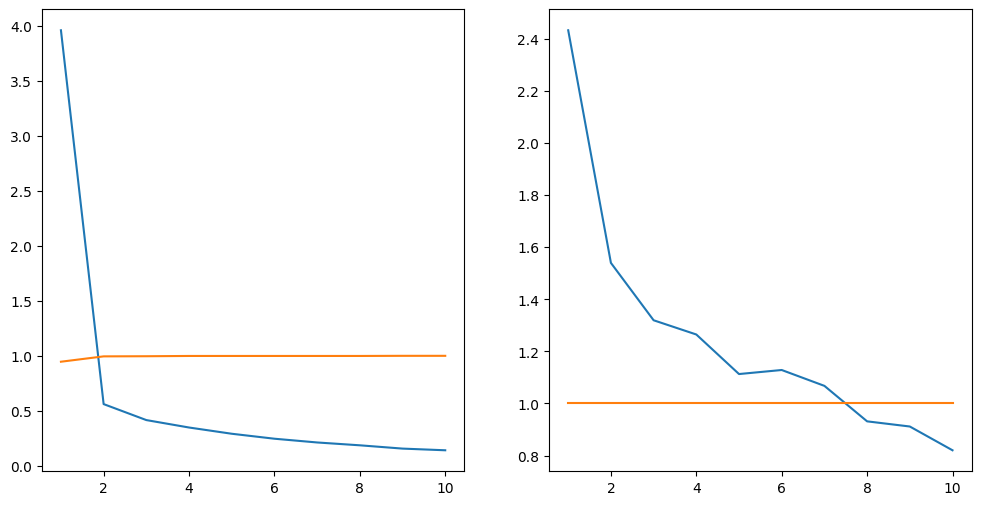

In [205]:
plt.figure(figsize=(12, 6))
epochs = range(1,num_epochs+1)

plt.subplot(1,2,1)
plt.plot(epochs,loss_train, label = "train loss")
plt.plot(epochs,list_acc_train,label = "accuracy train")
plt.subplot(1,2,2)
plt.plot(epochs,loss_test, label = "test loss")
plt.plot(epochs,list_acc_test,label = "accuracy test")
